##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c06_forecasting_with_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c06_forecasting_with_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
  
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

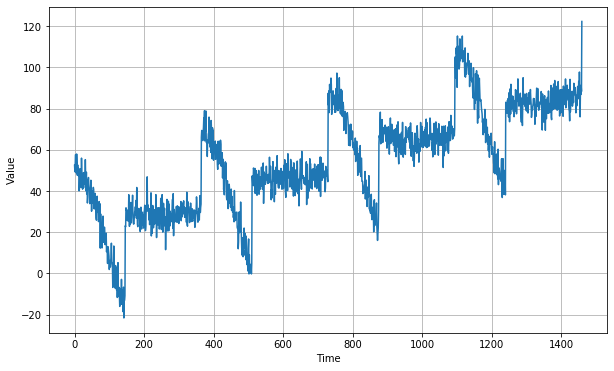

In [4]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Simple RNN Forecasting

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0) #scale
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 257ms/step - loss: 49.6373 - mae: 50.8965
Epoch 2/100
8/8 [==============================] - 0s 42ms/step - loss: 22.8817 - mae: 23.2030
Epoch 3/100
8/8 [==============================] - 0s 42ms/step - loss: 19.4102 - mae: 19.5125
Epoch 4/100
8/8 [==============================] - 0s 43ms/step - loss: 16.8363 - mae: 17.3121
Epoch 5/100
8/8 [==============================] - 0s 41ms/step - loss: 15.6861 - mae: 16.1971
Epoch 6/100
8/8 [==============================] - 0s 42ms/step - loss: 15.1294 - mae: 15.5585
Epoch 7/100
8/8 [==============================] - 0s 42ms/step - loss: 14.5319 - mae: 14.9520
Epoch 8/100
8/8 [==============================] - 0s 41ms/step - loss: 14.0056 - mae: 14.6318
Epoch 9/100
8/8 [==============================] - 0s 44ms/step - loss: 13.6949 - mae: 14.4190
Epoch 10/100
8/8 [==============================] - 0s 41ms/step - loss: 13.4131 - mae: 14.0410
Epoch 11/100
8/8 [==============================

8/8 [==============================] - 0s 41ms/step - loss: 10175.8258 - mae: 10248.2139
Epoch 86/100
8/8 [==============================] - 0s 41ms/step - loss: 11763.8429 - mae: 12104.1094
Epoch 87/100
8/8 [==============================] - 0s 43ms/step - loss: 5976.8466 - mae: 5774.2212
Epoch 88/100
8/8 [==============================] - 0s 42ms/step - loss: 6570.8430 - mae: 6889.1455
Epoch 89/100
8/8 [==============================] - 0s 42ms/step - loss: 9109.4508 - mae: 9200.8066
Epoch 90/100
8/8 [==============================] - 0s 44ms/step - loss: 12925.5634 - mae: 12420.8340
Epoch 91/100
8/8 [==============================] - 0s 43ms/step - loss: 19199.3386 - mae: 19259.2305
Epoch 92/100
8/8 [==============================] - 0s 42ms/step - loss: 9052.9014 - mae: 9146.7881
Epoch 93/100
8/8 [==============================] - 0s 42ms/step - loss: 8061.6803 - mae: 7766.5884
Epoch 94/100
8/8 [==============================] - 0s 41ms/step - loss: 9478.5091 - mae: 9899.0537
Epoch

[1e-07, 0.0001, 0, 30]

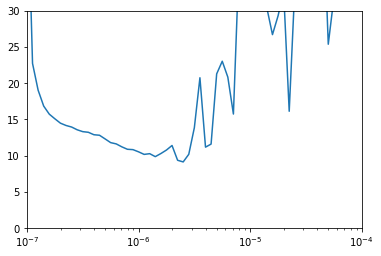

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
      8/Unknown - 1s 128ms/step - loss: 59.2327 - mae: 60.3561WARNING:tensorflow:From /home/itamar/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 3s 344ms/step - loss: 59.3020 - mae: 60.3561 - val_loss: 42.0141 - val_mae: 42.3808
Epoch 2/500
8/8 [==============================] - 2s 210ms/step - loss: 36.5803 - mae: 37.3106 - val_loss: 11.4775 - val_mae: 11.7886
Epoch 3/500
8/8 [==============================] - 0s 58ms/step - loss: 23.6567 - mae: 24.0715 - val_loss: 12.7571 - val_mae: 13.0818
Epoch 4/500
8/8 [==============================] - 0s 54ms/step - loss: 16.7817 - mae: 17.6511 - val_los

8/8 [==============================] - 0s 54ms/step - loss: 6.5232 - mae: 6.8913 - val_loss: 6.5937 - val_mae: 7.1063
Epoch 49/500
8/8 [==============================] - 0s 53ms/step - loss: 6.6330 - mae: 7.1850 - val_loss: 9.1465 - val_mae: 9.7356
Epoch 50/500
8/8 [==============================] - 0s 53ms/step - loss: 6.1231 - mae: 6.6079 - val_loss: 6.5479 - val_mae: 6.9105
Epoch 51/500
8/8 [==============================] - 0s 56ms/step - loss: 6.5599 - mae: 7.0111 - val_loss: 5.2565 - val_mae: 5.8497
Epoch 52/500
8/8 [==============================] - 0s 57ms/step - loss: 6.7354 - mae: 7.2520 - val_loss: 5.8359 - val_mae: 6.0993
Epoch 53/500
8/8 [==============================] - 0s 54ms/step - loss: 6.6055 - mae: 7.0938 - val_loss: 6.1224 - val_mae: 6.7777
Epoch 54/500
8/8 [==============================] - 0s 55ms/step - loss: 6.3323 - mae: 6.8662 - val_loss: 10.3036 - val_mae: 10.7968
Epoch 55/500
8/8 [==============================] - 0s 54ms/step - loss: 7.0508 - mae: 7.4640 

8/8 [==============================] - 0s 56ms/step - loss: 4.8879 - mae: 5.3443 - val_loss: 5.1157 - val_mae: 5.5626
Epoch 110/500
8/8 [==============================] - 0s 58ms/step - loss: 4.8760 - mae: 5.2962 - val_loss: 5.9152 - val_mae: 6.3077
Epoch 111/500
8/8 [==============================] - 0s 57ms/step - loss: 4.8943 - mae: 5.3039 - val_loss: 4.8984 - val_mae: 5.4111
Epoch 112/500
8/8 [==============================] - 0s 59ms/step - loss: 4.9600 - mae: 5.4269 - val_loss: 5.4896 - val_mae: 5.8615
Epoch 113/500
8/8 [==============================] - 0s 58ms/step - loss: 4.9802 - mae: 5.4836 - val_loss: 5.3333 - val_mae: 5.6938
Epoch 114/500
8/8 [==============================] - 0s 60ms/step - loss: 4.6993 - mae: 5.1513 - val_loss: 4.9177 - val_mae: 5.4885
Epoch 115/500
8/8 [==============================] - 0s 59ms/step - loss: 5.0021 - mae: 5.4323 - val_loss: 5.4333 - val_mae: 5.9721
Epoch 116/500
8/8 [==============================] - 0s 54ms/step - loss: 5.1852 - mae: 5.

In [9]:
model = keras.models.load_model("my_checkpoint")

In [10]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

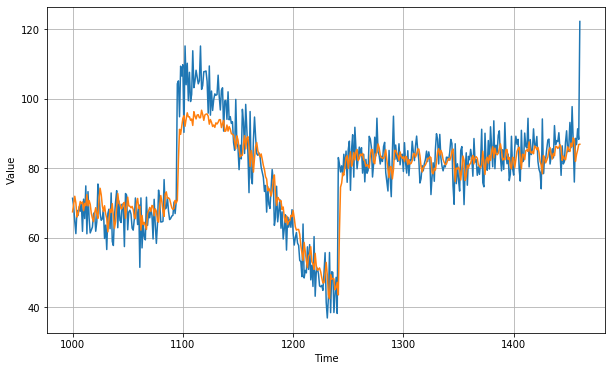

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [12]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.4141693

## Sequence-to-Sequence Forecasting

In [13]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [14]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]


In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 1s 147ms/step - loss: 51.8011 - mae: 53.0832
Epoch 2/100
8/8 [==============================] - 0s 42ms/step - loss: 25.6187 - mae: 25.9613
Epoch 3/100
8/8 [==============================] - 0s 44ms/step - loss: 23.2629 - mae: 23.7153
Epoch 4/100
8/8 [==============================] - 0s 43ms/step - loss: 20.7639 - mae: 21.3966
Epoch 5/100
8/8 [==============================] - 0s 42ms/step - loss: 19.3459 - mae: 19.9318
Epoch 6/100
8/8 [==============================] - 0s 43ms/step - loss: 18.7027 - mae: 19.1986
Epoch 7/100
8/8 [==============================] - 0s 43ms/step - loss: 18.1732 - mae: 18.6635
Epoch 8/100
8/8 [==============================] - 0s 43ms/step - loss: 17.6910 - mae: 18.2660
Epoch 9/100
8/8 [==============================] - 0s 42ms/step - loss: 17.3617 - mae: 17.9216
Epoch 10/100
8/8 [==============================] - 0s 43ms/step - loss: 16.9487 - mae: 17.5786
Epoch 11/100
8/8 [==============================

8/8 [==============================] - 0s 43ms/step - loss: 53.1733 - mae: 53.6680
Epoch 87/100
8/8 [==============================] - 0s 42ms/step - loss: 51.8067 - mae: 52.1962
Epoch 88/100
8/8 [==============================] - 0s 40ms/step - loss: 56.2959 - mae: 57.1553
Epoch 89/100
8/8 [==============================] - 0s 41ms/step - loss: 51.2936 - mae: 52.0443
Epoch 90/100
8/8 [==============================] - 0s 42ms/step - loss: 58.8653 - mae: 58.9642
Epoch 91/100
8/8 [==============================] - 0s 44ms/step - loss: 63.4808 - mae: 62.9096
Epoch 92/100
8/8 [==============================] - 0s 41ms/step - loss: 71.3537 - mae: 71.5132
Epoch 93/100
8/8 [==============================] - 0s 44ms/step - loss: 70.2844 - mae: 70.9309
Epoch 94/100
8/8 [==============================] - 0s 44ms/step - loss: 81.4103 - mae: 83.1281
Epoch 95/100
8/8 [==============================] - 0s 44ms/step - loss: 85.7708 - mae: 87.2088
Epoch 96/100
8/8 [==============================] - 0

[1e-07, 0.0001, 0, 30]

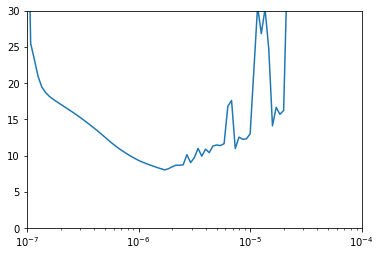

In [16]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 1s 158ms/step - loss: 55.8514 - mae: 56.2826 - val_loss: 17.6785 - val_mae: 18.0196
Epoch 2/500
8/8 [==============================] - 0s 55ms/step - loss: 33.9155 - mae: 35.1114 - val_loss: 17.4471 - val_mae: 18.0774
Epoch 3/500
8/8 [==============================] - 0s 55ms/step - loss: 28.3637 - mae: 28.6514 - val_loss: 35.8526 - val_mae: 36.0964
Epoch 4/500
8/8 [==============================] - 0s 56ms/step - loss: 21.0046 - mae: 21.6919 - val_loss: 27.8289 - val_mae: 28.4824
Epoch 5/500
8/8 [==============================] - 0s 58ms/step - loss: 17.9119 - mae: 18.5032 - val_loss: 17.8702 - val_mae: 18.4260
Epoch 6/500
8/8 [==============================] - 0s 58ms/step - loss: 15.3045 - mae: 15.8192 - val_loss: 10.6282 - val_mae: 11.1625
Epoch 7/500
8/8 [==============================] - 0s 58ms/step - loss: 13.8782 - mae: 14.3735 - val_loss: 8.7739 - val_mae: 9.2796
Epoch 8/500
8/8 [==============================] - 0s 59ms/step

8/8 [==============================] - 0s 58ms/step - loss: 6.3011 - mae: 6.7671 - val_loss: 5.7806 - val_mae: 6.2212
Epoch 64/500
8/8 [==============================] - 0s 56ms/step - loss: 6.2990 - mae: 6.7459 - val_loss: 5.5137 - val_mae: 5.9787
Epoch 65/500
8/8 [==============================] - 0s 56ms/step - loss: 6.2654 - mae: 6.7236 - val_loss: 5.6845 - val_mae: 6.1720
Epoch 66/500
8/8 [==============================] - 0s 56ms/step - loss: 6.2617 - mae: 6.7030 - val_loss: 5.4796 - val_mae: 6.0023
Epoch 67/500
8/8 [==============================] - 0s 58ms/step - loss: 6.1849 - mae: 6.6823 - val_loss: 5.5488 - val_mae: 6.0374
Epoch 68/500
8/8 [==============================] - 0s 56ms/step - loss: 6.1961 - mae: 6.6636 - val_loss: 5.5117 - val_mae: 6.0098
Epoch 69/500
8/8 [==============================] - 0s 55ms/step - loss: 6.1731 - mae: 6.6441 - val_loss: 5.5431 - val_mae: 6.0296
Epoch 70/500
8/8 [==============================] - 0s 56ms/step - loss: 6.1254 - mae: 6.6271 - 

8/8 [==============================] - 0s 57ms/step - loss: 5.4465 - mae: 5.9188 - val_loss: 5.2403 - val_mae: 5.7024
Epoch 126/500
8/8 [==============================] - 0s 54ms/step - loss: 5.4472 - mae: 5.9083 - val_loss: 5.1686 - val_mae: 5.6640
Epoch 127/500
8/8 [==============================] - 0s 57ms/step - loss: 5.4259 - mae: 5.8979 - val_loss: 5.1556 - val_mae: 5.6217
Epoch 128/500
8/8 [==============================] - 0s 56ms/step - loss: 5.3968 - mae: 5.8928 - val_loss: 5.2615 - val_mae: 5.7583
Epoch 129/500
8/8 [==============================] - 0s 56ms/step - loss: 5.4104 - mae: 5.8810 - val_loss: 5.1096 - val_mae: 5.6117
Epoch 130/500
8/8 [==============================] - 0s 55ms/step - loss: 5.3607 - mae: 5.8681 - val_loss: 5.2225 - val_mae: 5.6829
Epoch 131/500
8/8 [==============================] - 0s 55ms/step - loss: 5.3659 - mae: 5.8576 - val_loss: 5.1866 - val_mae: 5.6872
Epoch 132/500
8/8 [==============================] - 0s 57ms/step - loss: 5.3826 - mae: 5.

In [18]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

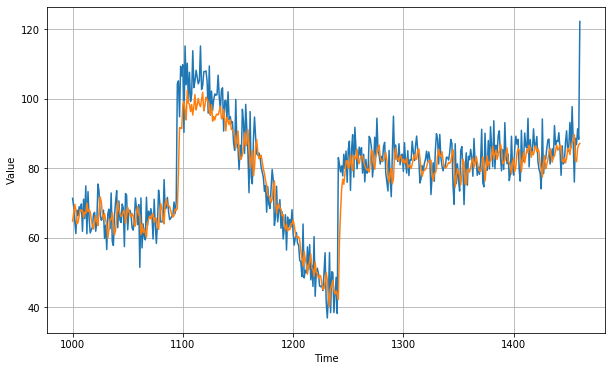

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [20]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.1336293